In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse
import re
import warnings
from sklearn.metrics import classification_report
import shap
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [46]:
from typing import List, Dict, Union, Tuple, Optional
import numpy as np
import re
import logging
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import shap
from urllib.parse import urlparse
import hashlib
import json

class HTMLPhishingDetector:
    def __init__(
        self,
        iterations: int = 1000,
        learning_rate: float = 0.1,
        random_state: int = 42,
        model_path: Optional[str] = None
    ):
        """
        Initialize the phishing detector with enhanced configuration.
        
        Args:
            iterations: Number of boosting iterations (default: 1000)
            learning_rate: Learning rate for gradient descent (default: 0.1)
            random_state: Random seed for reproducibility (default: 42)
            model_path: Path to load a pre-trained model (default: None)
        """
        self.model = CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            random_seed=random_state,
            verbose=True,
            eval_metric='AUC',
            loss_function='Logloss',
            early_stopping_rounds=50,  # Added early stopping
            max_depth=6,  # Control tree depth
            l2_leaf_reg=3,  # L2 regularization
            border_count=128  # Increase feature discretization
        )
        self.scaler = StandardScaler()
        self.feature_names: List[str] = []
        self.explainer = None
        self._initialize_logging()
        
        # Load pre-trained model if provided
        if model_path:
            self.load_model(model_path)
            
        # Initialize common patterns
        self._initialize_patterns()
        
        # Load known phishing patterns
        self._load_phishing_patterns()

    def _initialize_logging(self):
        """Initialize enhanced logging configuration."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            handlers=[
                logging.StreamHandler(),
                logging.FileHandler('phishing_detector.log')
            ]
        )
        self.logger = logging.getLogger(__name__)

    def _initialize_patterns(self):
        """Initialize regex patterns and common indicators."""
        self.patterns = {
            'ip_address': re.compile(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'),
            'data_uri': re.compile(r'data:(?:[^;]*;)*(?:base64,)?[a-zA-Z0-9+/]+={0,2}'),
            'obfuscated_js': re.compile(
                r'eval\(|String\.fromCharCode|unescape\(|escape\(|atob\(|btoa\('
                r'|decodeURIComponent\(|encodeURIComponent\(|debugger|'
                r'\\x[0-9a-fA-F]{2}|\\u[0-9a-fA-F]{4}|\\[0-7]{3}'
            ),
            'suspicious_functions': re.compile(
                r'document\.write|document\.location|window\.location|'
                r'document\.cookie|localStorage|sessionStorage'
            ),
            'urgent_words': re.compile(
                r'urgent|immediate|verify|suspend|restrict|limit|cancel|account|'
                r'security|unauthorized|login|sign.?in|expires?|password|'
                r'credentials|confirm|update|validate|required|important'
            )
        }

    def _load_phishing_patterns(self):
        """Load known phishing patterns and signatures."""
        # This could be expanded to load from a database or file
        self.known_patterns = {
            'fake_domains': [
                'paypa1.com', 'amaz0n.com', 'g00gle.com',
                'faceb00k.com', 'twltter.com'
            ],
            'suspicious_tlds': [
                '.tk', '.ml', '.ga', '.cf', '.gq', '.xyz'
            ],
            'common_redirects': [
                'url=', 'redirect=', 'return=', 'redir=', 'r=', 'u='
            ]
        }

    def extract_html_features(self, html_content: str) -> np.ndarray:
        """
        Extract enhanced features from HTML content for phishing detection.
        
        Args:
            html_content: Raw HTML string
            
        Returns:
            np.ndarray: Array of extracted feature values
        """
        if not html_content or not isinstance(html_content, str):
            raise ValueError("HTML content must be a non-empty string")
            
        try:
            features = {}
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Basic form and input analysis
            features.update(self._extract_form_features(soup))
            
            # Enhanced link analysis
            features.update(self._extract_link_features(soup))
            
            # Script and resource analysis
            features.update(self._extract_script_features(soup))
            
            # Content and text analysis
            features.update(self._extract_content_features(soup))
            
            # Security indicators
            features.update(self._extract_security_features(soup))
            
            # Technical indicators
            features.update(self._extract_technical_features(soup, html_content))
            
            # Normalize features if needed
            features = self._normalize_features(features)
            
            return np.array(list(features.values()))
            
        except Exception as e:
            self.logger.error(f"Error extracting features: {str(e)}")
            raise

    def _extract_form_features(self, soup: BeautifulSoup) -> Dict[str, float]:
        """Extract enhanced form-related features."""
        features = {}
        forms = soup.find_all('form')
        
        features['form_count'] = len(forms)
        features['password_fields'] = len(soup.find_all('input', {'type': 'password'}))
        
        # Analyze form actions
        external_actions = 0
        suspicious_actions = 0
        for form in forms:
            action = form.get('action', '').lower()
            if action.startswith(('http', '//')):
                external_actions += 1

                    
        features['external_form_actions'] = external_actions
        features['suspicious_form_actions'] = suspicious_actions
        
        # Enhanced input field analysis
        input_fields = soup.find_all('input')
        features['input_field_count'] = len(input_fields)
        
        sensitive_types = {
            'password', 'email', 'tel', 'credit-card', 'card-number', 
            'ssn', 'social-security', 'bank-account', 'routing-number'
        }
        
        sensitive_count = 0
        suspicious_names = 0
        for field in input_fields:
            field_type = field.get('type', '').lower()
            field_name = field.get('name', '').lower()
            
            if (field_type in sensitive_types or 
                any(term in field_name for term in sensitive_types)):
                sensitive_count += 1
                
            if self._is_suspicious_input_name(field_name):
                suspicious_names += 1
                
        features['sensitive_input_count'] = sensitive_count
        features['suspicious_input_names'] = suspicious_names
        
        return features

    def _extract_link_features(self, soup: BeautifulSoup) -> Dict[str, float]:
        """Extract enhanced link-related features."""
        features = {}
        links = soup.find_all('a')
        features['link_count'] = len(links)
        
        external_links = 0
        internal_links = 0
        suspicious_links = 0
        redirect_links = 0
        same_text_diff_targets = 0
        
        # Track unique domains and their frequencies
        domains = {}
        link_texts = {}
        
        for link in links:
            href = link.get('href', '').strip()
            text = link.get_text().strip()
            
            if not href:
                continue
                
            # Analyze link target
            if href.startswith(('http', '//', 'www.')):
                external_links += 1
                    
                if self._contains_redirect(href):
                    redirect_links += 1
                    
            elif href and not href.startswith('#'):
                internal_links += 1
                
            # Analyze link text vs target mismatch
            if text:
                if text in link_texts:
                    if href != link_texts[text]:
                        same_text_diff_targets += 1
                else:
                    link_texts[text] = href
                    
        total_links = external_links + internal_links
        
        features.update({
            'external_links_ratio': external_links / (total_links + 1),
            'suspicious_link_ratio': suspicious_links / (total_links + 1),
            'redirect_link_ratio': redirect_links / (total_links + 1),
            'domain_diversity': len(domains) / (total_links + 1),
            'max_domain_concentration': max(domains.values()) / (total_links + 1) if domains else 0,
            'same_text_diff_targets': same_text_diff_targets
        })
        
        return features

    def _extract_script_features(self, soup: BeautifulSoup) -> Dict[str, float]:
        """Extract enhanced script-related features."""
        features = {}
        scripts = soup.find_all('script')
        
        features['script_count'] = len(scripts)
        features['external_scripts'] = sum(1 for script in scripts 
                                         if script.get('src', '').startswith(('http', '//')))
        
        # Analyze script content
        obfuscated_count = 0
        suspicious_functions = 0
        encoded_strings = 0
        
        for script in scripts:
            content = script.string if script.string else ''
            if not content:
                continue
                
            if self.patterns['obfuscated_js'].search(content):
                obfuscated_count += 1
                
            if self.patterns['suspicious_functions'].search(content):
                suspicious_functions += 1
                
            # Check for long encoded strings
            encoded_strings += len(re.findall(r'[\w+/]{50,}={0,2}', content))
            
        features.update({
            'obfuscated_scripts': obfuscated_count,
            'suspicious_functions': suspicious_functions,
            'encoded_strings': encoded_strings
        })
        
        return features

    def _extract_content_features(self, soup: BeautifulSoup) -> Dict[str, float]:
        """Extract enhanced content-related features."""
        features = {}
        
        # Get all text content
        text_content = ' '.join(soup.stripped_strings).lower()
        features['text_length'] = len(text_content)
        
        # Analyze text characteristics
        features.update({
            'urgent_word_count': len(self.patterns['urgent_words'].findall(text_content)),
            'suspicious_character_ratio': self._calculate_suspicious_chars(text_content),
            'language_mix_score': self._calculate_language_mix(text_content)
        })
        
        # Hidden elements analysis
        hidden_elements = soup.find_all(
            ['div', 'span', 'input', 'a'], 
            style=re.compile(r'display\s*:\s*none|visibility\s*:\s*hidden', re.I)
        )
        features['hidden_element_count'] = len(hidden_elements)
        
        # Analyze element positioning
        features['suspicious_positioning'] = self._analyze_element_positioning(soup)
        
        return features

    def _extract_security_features(self, soup: BeautifulSoup) -> Dict[str, float]:
        """Extract enhanced security-related features."""
        features = {}
        
        # SSL/HTTPS analysis
        features['has_https_link'] = int(bool(soup.find('a', href=re.compile(r'^https://'))))
        
        # Security headers and meta tags
        meta_tags = soup.find_all('meta')
        features['meta_tag_count'] = len(meta_tags)
        
        security_headers = {
            'content-security-policy': 0,
            'x-frame-options': 0,
            'x-xss-protection': 0
        }
        
        for tag in meta_tags:
            http_equiv = tag.get('http-equiv', '').lower()
            if http_equiv in security_headers:
                security_headers[http_equiv] = 1
                
        features.update(security_headers)
        
        # Favicon analysis
        features['has_favicon'] = int(bool(
            soup.find('link', rel=re.compile(r'^(shortcut\s+)?icon$', re.I))
        ))
        
        return features

    def _extract_technical_features(self, soup: BeautifulSoup, html_content: str) -> Dict[str, float]:
        """Extract enhanced technical features."""
        features = {}
        
        # HTML structure analysis
        features['tag_density'] = len(soup.find_all(True)) / (len(html_content) + 1)
        features['max_depth'] = self._calculate_max_depth(soup)
        
        # Resource loading analysis
        resources = soup.find_all(['img', 'script', 'link', 'iframe'])
        features['resource_count'] = len(resources)
        
        external_resources = 0
        data_uri_resources = 0
        for resource in resources:
            src = resource.get('src', '') or resource.get('href', '')
            if src.startswith(('http', '//')):
                external_resources += 1
            if src.startswith('data:'):
                data_uri_resources += 1
                
        features['external_resource_ratio'] = external_resources / (len(resources) + 1)
        features['data_uri_ratio'] = data_uri_resources / (len(resources) + 1)
        
        # Code characteristics
        features['html_length'] = len(html_content)
        features['comments_length'] = sum(len(str(comment)) for comment in soup.find_all(string=lambda text: isinstance(text, str)))
        
        return features

    def _normalize_features(self, features: Dict[str, float]) -> Dict[str, float]:
        """Normalize feature values to appropriate ranges."""
        # Ensure all values are numeric
        for key, value in features.items():
            if isinstance(value, bool):
                features[key] = float(value)
            elif not isinstance(value, (int, float)):
                features[key] = float(value)
                
        # Cap extreme values
        for key, value in features.items():
            if key.endswith('_ratio'):
                features[key] = min(max(value, 0.0), 1.0)
            elif key.endswith('_count'):
                features[key] = min(value, 1000)  # Cap counts at reasonable maximum
                
        return features


    def _contains_redirect(self, url: str) -> bool:
        """Check if URL contains redirect patterns."""
        try:
            parsed = urlparse(url)
            query = parsed.query.lower()
            
            return any(pattern in query for pattern in self.known_patterns['common_redirects'])
            
        except Exception:
            return False

    def _is_suspicious_input_name(self, name: str) -> bool:
        """Check if input field name is suspicious."""
        suspicious_patterns = [
            r'(?:card|cc).*num',
            r'(?:cvv|cvc|ccv)',
            r'ssn',
            r'(?:bank|account).*(?:num|no)',
            r'routing',
            r'swift',
            r'passw(?:or)?d',
        ]
        
        return any(re.search(pattern, name, re.I) for pattern in suspicious_patterns)

    def _calculate_suspicious_chars(self, text: str) -> float:
        """Calculate ratio of suspicious characters in text."""
        suspicious_chars = re.findall(r'[^\x00-\x7F]|[\\/<>]', text)
        return len(suspicious_chars) / (len(text) + 1)

    def _calculate_language_mix(self, text: str) -> float:
        """Calculate score for mixed language usage."""
        # Simple heuristic for mixed scripts
        scripts = {
            'latin': len(re.findall(r'[a-zA-Z]', text)),
            'cyrillic': len(re.findall(r'[а-яА-Я]', text)),
            'chinese': len(re.findall(r'[\u4e00-\u9fff]', text)),
            'arabic': len(re.findall(r'[\u0600-\u06ff]', text)),
        }
        
        total_chars = sum(scripts.values())
        if total_chars == 0:
            return 0
            
        # Calculate entropy-like measure of script mixing
        proportions = [count / total_chars for count in scripts.values() if count > 0]
        return -sum(p * np.log(p) for p in proportions)

    def _analyze_element_positioning(self, soup: BeautifulSoup) -> int:
        """Analyze suspicious element positioning."""
        suspicious_count = 0
        
        # Check for elements positioned outside viewport
        positioned_elements = soup.find_all(style=re.compile(
            r'position\s*:\s*absolute|position\s*:\s*fixed'
        ))
        
        for element in positioned_elements:
            style = element.get('style', '')
            # Check for negative positioning or very large values
            if re.search(r'(?:top|left|right|bottom)\s*:\s*-?\d{4,}px', style):
                suspicious_count += 1
            # Check for positioning far outside normal viewport
            if re.search(r'(?:top|left|right|bottom)\s*:\s*[1-9]\d{3,}px', style):
                suspicious_count += 1
                
        return suspicious_count

    def _calculate_max_depth(self, soup: BeautifulSoup) -> int:
        """Calculate maximum nesting depth of HTML elements."""
        max_depth = 0
        
        for element in soup.find_all(True):
            depth = len(list(element.parents))
            max_depth = max(max_depth, depth)
            
        return max_depth

    def save_model(self, path: str):
        """Save the trained model and associated data."""
        model_data = {
            'model': self.model.save_model(),
            'scaler': self.scaler,
            'feature_names': self.feature_names
        }
        
        with open(path, 'wb') as f:
            import pickle
            pickle.dump(model_data, f)

    def load_model(self, path: str):
        """Load a trained model and associated data."""
        with open(path, 'rb') as f:
            import pickle
            model_data = pickle.load(f)
            
        self.model.load_model(model_data['model'])
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']

    def cross_validate(self, X: np.ndarray, y: np.ndarray, folds: int = 5) -> Dict[str, float]:
        """Perform cross-validation and return performance metrics."""
        from sklearn.model_selection import cross_validate
        
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        scores = cross_validate(
            self.model, 
            X, 
            y, 
            cv=folds,
            scoring=metrics,
            return_train_score=True
        )
        
        return {
            metric: float(scores[f'test_{metric}'].mean()) 
            for metric in metrics
        }

    def prepare_dataset(self, html_contents: List[str], labels: List[int]) -> np.ndarray:
        """
        Prepare features from multiple HTML contents for training or prediction.
        
        Args:
            html_contents: List of HTML content strings
            labels: List of corresponding labels (1 for phishing, 0 for legitimate)
            
        Returns:
            np.ndarray: Array of extracted features for all HTML contents
            
        Raises:
            ValueError: If input lengths don't match or if extraction fails
        """
        if len(html_contents) != len(labels):
            raise ValueError("Number of HTML contents must match number of labels")
            
        features_list = []
        failed_indices = []
        
        # Process each HTML content
        for i, html in enumerate(html_contents):
            try:
                # Extract features for current HTML
                features = self.extract_html_features(html)
                features_list.append(features)
            except Exception as e:
                self.logger.warning(f"Failed to extract features for sample {i}: {str(e)}")
                failed_indices.append(i)
                continue
        
        if not features_list:
            raise ValueError("Failed to extract features from all samples")
        
        # Convert to numpy array
        features_array = np.array(features_list)
        
        # Initialize feature names if not already set
        if not self.feature_names:
            self.feature_names = [
                # Basic form features
                'form_count', 'password_fields', 'external_form_actions',
                'suspicious_form_actions', 'input_field_count', 'sensitive_input_count',
                'suspicious_input_names',
                
                # Link features
                'link_count', 'external_links_ratio', 'suspicious_link_ratio',
                'redirect_link_ratio', 'domain_diversity', 'max_domain_concentration',
                'same_text_diff_targets',
                
                # Script features
                'script_count', 'external_scripts', 'obfuscated_scripts',
                'suspicious_functions', 'encoded_strings',
                
                # Content features
                'text_length', 'urgent_word_count', 'suspicious_character_ratio',
                'language_mix_score', 'hidden_element_count', 'suspicious_positioning',
                
                # Security features
                'has_https_link', 'content-security-policy', 'x-frame-options',
                'x-xss-protection', 'has_favicon', 'meta_tag_count',
                
                # Technical features
                'tag_density', 'max_depth', 'resource_count', 'external_resource_ratio',
                'data_uri_ratio', 'html_length', 'comments_length'
            ]
        
        # Verify feature dimensions
        if features_array.shape[1] != len(self.feature_names):
            raise ValueError(
                f"Feature extraction produced {features_array.shape[1]} features, "
                f"but expected {len(self.feature_names)}"
            )
        
        # Report on failed extractions
        if failed_indices:
            self.logger.warning(
                f"Failed to process {len(failed_indices)} samples at indices: {failed_indices}"
            )
        
        # Log feature statistics
        self._log_feature_statistics(features_array)
        
        return features_array

    def _log_feature_statistics(self, features: np.ndarray):
        """Log basic statistics about extracted features."""
        try:
            feature_means = np.mean(features, axis=0)
            feature_stds = np.std(features, axis=0)
            
            self.logger.info("Feature statistics:")
            for name, mean, std in zip(self.feature_names, feature_means, feature_stds):
                self.logger.info(f"{name}: mean={mean:.3f}, std={std:.3f}")
                
            # Log potential issues
            constant_features = np.where(feature_stds == 0)[0]
            if len(constant_features) > 0:
                self.logger.warning(
                    "Constant features detected: " +
                    ", ".join(self.feature_names[i] for i in constant_features)
                )
                
            # Check for extreme values
            max_values = np.max(features, axis=0)
            min_values = np.min(features, axis=0)
            for name, max_val, min_val in zip(self.feature_names, max_values, min_values):
                if max_val > 1000 or min_val < -1000:
                    self.logger.warning(
                        f"Extreme values detected for {name}: "
                        f"min={min_val:.2f}, max={max_val:.2f}"
                    )
                    
        except Exception as e:
            self.logger.error(f"Error logging feature statistics: {str(e)}")
    def train(self, X: np.ndarray, y: np.ndarray) -> 'HTMLPhishingDetector':
        """
        Обучение модели обнаружения фишинга с использованием CatBoost.
        
        Args:
            X: np.ndarray - матрица признаков
            y: np.ndarray - вектор меток (1 - фишинг, 0 - легитимный)
            
        Returns:
            HTMLPhishingDetector: обученный экземпляр класса
            
        Raises:
            ValueError: если размерности данных неверны
        """
        if X.shape[1] != len(self.feature_names):
            raise ValueError(
                f"Ожидалось {len(self.feature_names)} признаков, "
                f"получено {X.shape[1]}"
            )
        
        try:
            # Масштабирование признаков
            X_scaled = self.scaler.fit_transform(X)
            
            # Подготовка данных для обучения
            train_pool = Pool(
                data=X_scaled,
                label=y,
                feature_names=self.feature_names
            )
            
            # Создание валидационного набора
            X_train, X_val, y_train, y_val = train_test_split(
                X_scaled, y, 
                test_size=0.2, 
                random_state=42
            )
            
            eval_pool = Pool(
                data=X_val,
                label=y_val,
                feature_names=self.feature_names
            )
            
            # Обучение модели CatBoost с мониторингом
            self.model.fit(
                train_pool,
                eval_set=eval_pool,
                plot=True,  # Построение графиков обучения
                verbose=100  # Вывод прогресса каждые 100 итераций
            )
            
            # Инициализация SHAP объяснений
            try:
                self.explainer = shap.TreeExplainer(self.model)
                self.logger.info("SHAP объяснения успешно инициализированы")
            except Exception as e:
                self.logger.warning(f"Не удалось инициализировать SHAP: {str(e)}")
                self.explainer = None
            
            # Оценка качества на валидационном наборе
            val_predictions = self.model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, val_predictions)
            self.logger.info(f"Validation AUC: {val_auc:.3f}")
            
            return self
            
        except Exception as e:
            self.logger.error(f"Ошибка при обучении модели: {str(e)}")
            raise

    def predict(self, html_content: str) -> Dict[str, Union[bool, float, str, List]]:
        """
        Определение является ли HTML-страница фишинговой и объяснение причин.
        
        Args:
            html_content: str - HTML-содержимое страницы
            
        Returns:
            Dict с результатами:
                - is_phishing: bool - является ли страница фишинговой
                - confidence: float - уверенность предсказания
                - explanation: str - объяснение на русском языке
                - feature_importance: List - важнейшие признаки
                - suspicious_elements: List - подозрительные элементы
                - feature_values: Dict - значения признаков
        """
        try:
            # Извлечение признаков
            features = self.extract_html_features(html_content)
            features_scaled = self.scaler.transform(features.reshape(1, -1))
            
            # Получение предсказания и вероятностей
            prediction = self.model.predict(features_scaled)[0]
            probabilities = self.model.predict_proba(features_scaled)[0]
            confidence = float(probabilities[1] if prediction == 1 else probabilities[0])
            
            # Генерация объяснений
            explanation = "Объяснение недоступно"
            feature_importance = []
            
            if self.explainer:
                try:
                    # Получение SHAP-значений
                    shap_values = self.explainer.shap_values(features_scaled)
                    if isinstance(shap_values, list):
                        shap_vals = shap_values[1][0] if prediction == 1 else shap_values[0][0]
                    else:
                        shap_vals = shap_values[0]
                    
                    # Генерация объяснения и важности признаков
                    explanation = self._generate_explanation(features, shap_vals)
                    feature_importance = self._get_feature_importance(features, shap_vals)
                except Exception as e:
                    self.logger.warning(f"Ошибка при генерации SHAP-объяснений: {str(e)}")
            
            # Поиск подозрительных элементов
            suspicious_elements = self._identify_suspicious_elements(html_content)
            
            # Формирование результата
            result = {
                'is_phishing': bool(prediction),
                'confidence': confidence,
                'explanation': explanation,
                'feature_importance': feature_importance[:5],  # топ-5 важных признаков
                'suspicious_elements': suspicious_elements,
                'feature_values': dict(zip(self.feature_names, features))
            }
            
            # Логирование результата
            self.logger.info(
                f"Предсказание: {'фишинг' if prediction else 'легитимный'}, "
                f"уверенность: {confidence:.2f}"
            )
            
            return result
            
        except Exception as e:
            self.logger.error(f"Ошибка при выполнении предсказания: {str(e)}")
            raise

    def _generate_explanation(self, features: np.ndarray, shap_values: np.ndarray) -> str:
        """
        Генерация понятного объяснения на русском языке на основе SHAP-значений.
        
        Args:
            features: значения признаков
            shap_values: SHAP-значения для признаков
            
        Returns:
            str: текстовое объяснение на русском языке
        """
        try:
            feature_importance = self._get_feature_importance(features, shap_values)
            explanations = []
            
            for feature, value, importance in feature_importance[:5]:
                if abs(importance) < 0.1:  # игнорируем малозначимые признаки
                    continue
                
                # Проверка различных признаков и формирование объяснений
                if feature == 'external_links_ratio':
                    explanations.append(
                        f"{'Подозрительно большое' if importance > 0 else 'Нормальное'} "
                        f"количество внешних ссылок ({value:.1%})"
                    )
                    
                elif feature == 'suspicious_link_ratio' and value > 0:
                    explanations.append(
                        f"Обнаружены подозрительные ссылки "
                        f"(например, использование IP-адресов вместо доменных имён)"
                    )
                    
                elif feature == 'password_fields':
                    explanations.append(
                        f"{'Подозрительное' if importance > 0 else 'Нормальное'} "
                        f"количество полей для ввода пароля ({int(value)})"
                    )
                    
                elif feature == 'hidden_element_count':
                    explanations.append(
                        f"{'Подозрительное' if importance > 0 else 'Нормальное'} "
                        f"количество скрытых элементов на странице ({int(value)})"
                    )
                    
                elif feature == 'has_urgent_text' and value == 1:
                    explanations.append(
                        "Страница содержит текст, создающий ложное чувство срочности "
                        "или угрозы"
                    )
                    
                elif feature == 'sensitive_input_count':
                    explanations.append(
                        f"{'Подозрительное' if importance > 0 else 'Нормальное'} "
                        f"количество полей для ввода конфиденциальных данных ({int(value)})"
                    )
                    
                elif feature == 'obfuscated_scripts':
                    explanations.append(
                        f"Обнаружен{'о' if value == 1 else 'ы'} {int(value)} "
                        f"{'подозрительный скрипт' if value == 1 else 'подозрительных скриптов'} "
                        f"с обфусцированным кодом"
                    )
                    
                elif feature == 'suspicious_positioning':
                    explanations.append(
                        f"Обнаружено {int(value)} элементов с подозрительным "
                        f"позиционированием на странице"
                    )
                    
                elif feature == 'domain_diversity':
                    if importance > 0 and value > 0.5:
                        explanations.append(
                            "Подозрительно большое разнообразие доменов в ссылках"
                        )
                
                elif feature == 'has_favicon' and value == 0:
                    explanations.append(
                        "Отсутствует favicon, что нетипично для легитимных сайтов"
                    )
            
            if not explanations:
                return "Значительных подозрительных признаков не обнаружено."
            
            # Формирование итогового объяснения
            main_explanation = " и ".join(explanations) + "."
            
            # Добавление общего вывода
            if len(explanations) > 2:
                main_explanation += (
                    "\nСовокупность этих признаков характерна для фишинговых страниц."
                )
            
            return main_explanation
            
        except Exception as e:
            self.logger.warning(f"Ошибка при генерации объяснения: {str(e)}")
            return "Не удалось сгенерировать объяснение из-за технической ошибки."
    def _get_feature_importance(
            self, 
            features: np.ndarray, 
            shap_values: np.ndarray
        ) -> List[Tuple[str, float, float]]:
        """
        Расчёт важности признаков с использованием SHAP-значений.
        
        Args:
            features: значения признаков
            shap_values: SHAP-значения
            
        Returns:
            List[Tuple]: список кортежей (имя признака, значение, важность)
        """
        feature_importance = []
        
        for name, value, importance in zip(self.feature_names, features, shap_values):
            # Приведение к обычным Python-типам из numpy
            value = float(np.asarray(value).item() if hasattr(value, 'item') else value)
            importance = float(np.asarray(importance).item() if hasattr(importance, 'item') else importance)
            feature_importance.append((name, value, importance))
        
        # Сортировка по абсолютному значению важности
        return sorted(feature_importance, key=lambda x: abs(x[2]), reverse=True)

    def _identify_suspicious_elements(self, html_content: str) -> List[Dict[str, str]]:
        """
        Поиск подозрительных элементов в HTML-содержимом.
        
        Args:
            html_content: HTML-содержимое
            
        Returns:
            List[Dict]: список подозрительных элементов с их описанием
        """
        try:
            soup = BeautifulSoup(html_content, 'html.parser')
            suspicious = []
            
            # Проверка форм с внешними действиями
            for form in soup.find_all('form'):
                action = form.get('action', '')
                if action.startswith(('http', '//')):
                    suspicious.append({
                        'type': 'form',
                        'issue': 'Форма отправляет данные на внешний сайт',
                        'element': str(form)[:200] + '...' if len(str(form)) > 200 else str(form)
                    })

            # Проверка подозрительных скриптов
            scripts = soup.find_all('script')
            for script in scripts:
                content = script.string if script.string else ''
                if content and self.patterns['obfuscated_js'].search(content):
                    suspicious.append({
                        'type': 'script',
                        'issue': 'Обнаружен обфусцированный JavaScript-код',
                        'element': str(script)[:200] + '...' if len(str(script)) > 200 else str(script)
                    })

            # Проверка подозрительных iframe
            iframes = soup.find_all('iframe')
            for iframe in iframes:
                src = iframe.get('src', '')
                if src.startswith(('http', '//')) or not src:
                    suspicious.append({
                        'type': 'iframe',
                        'issue': 'Подозрительное использование iframe',
                        'element': str(iframe)
                    })

            # Проверка data URI в ссылках или формах
            elements_with_uri = soup.find_all(['a', 'form', 'img'], href=re.compile(r'^data:'))
            for element in elements_with_uri:
                suspicious.append({
                    'type': element.name,
                    'issue': 'Использование подозрительного data URI',
                    'element': str(element)
                })

            # Проверка скрытых элементов
            hidden_elements = soup.find_all(
                ['div', 'span', 'input', 'p'], 
                style=re.compile(r'display\s*:\s*none|visibility\s*:\s*hidden', re.I)
            )
            for element in hidden_elements:
                if element.find(['form', 'input', 'select']):
                    suspicious.append({
                        'type': 'hidden_element',
                        'issue': 'Скрытая форма или поле ввода',
                        'element': str(element)[:200] + '...' if len(str(element)) > 200 else str(element)
                    })

            # Проверка элементов, расположенных за пределами видимой области
            positioned_elements = soup.find_all(
                style=re.compile(r'position\s*:\s*absolute|position\s*:\s*fixed')
            )
            for element in positioned_elements:
                style = element.get('style', '')
                if re.search(r'(?:top|left|right|bottom)\s*:\s*-?\d{4,}px', style):
                    suspicious.append({
                        'type': 'positioning',
                        'issue': 'Элемент расположен за пределами видимой области',
                        'element': str(element)[:200] + '...' if len(str(element)) > 200 else str(element)
                    })

            # Проверка смешанного контента (HTTP на HTTPS)
            if soup.find('meta', {'content': re.compile('https')}):
                mixed_content = soup.find_all(
                    ['img', 'script', 'link', 'iframe'], 
                    src=re.compile(r'^http:\/\/')
                )
                for element in mixed_content:
                    suspicious.append({
                        'type': element.name,
                        'issue': 'Небезопасное содержимое (HTTP на HTTPS)',
                        'element': str(element)
                    })

            # Проверка подозрительных редиректов
            for a in soup.find_all('a'):
                href = a.get('href', '')
                if any(pattern in href.lower() for pattern in self.known_patterns['common_redirects']):
                    suspicious.append({
                        'type': 'redirect',
                        'issue': 'Подозрительный редирект',
                        'element': str(a)
                    })

            return suspicious
            
        except Exception as e:
            self.logger.error(f"Ошибка при поиске подозрительных элементов: {str(e)}")
            return []

In [47]:
import json
data = json.load(open('webs.json', 'r', encoding='utf-8'))[:12000]

In [ ]:
len(data)

In [13]:
utils = DatasetUtils()

In [36]:
html_contents = [item['text'] for item in data]
labels = [item['label'] for item in data]

In [48]:
# Initialize detector
detector = HTMLPhishingDetector(
    iterations=2000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    random_state=42  # Random seed
)


In [38]:
# Prepare dataset
X = detector.prepare_dataset(html_contents, labels)
y = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

2024-12-01 17:46:18,706 - __main__ - INFO - Feature statistics:
2024-12-01 17:46:18,707 - __main__ - INFO - form_count: mean=1.139, std=1.602
2024-12-01 17:46:18,707 - __main__ - INFO - password_fields: mean=0.312, std=0.804
2024-12-01 17:46:18,708 - __main__ - INFO - external_form_actions: mean=0.355, std=0.850
2024-12-01 17:46:18,708 - __main__ - INFO - suspicious_form_actions: mean=0.000, std=0.000
2024-12-01 17:46:18,708 - __main__ - INFO - input_field_count: mean=5.505, std=9.526
2024-12-01 17:46:18,709 - __main__ - INFO - sensitive_input_count: mean=0.667, std=1.387
2024-12-01 17:46:18,709 - __main__ - INFO - suspicious_input_names: mean=0.233, std=0.674
2024-12-01 17:46:18,709 - __main__ - INFO - link_count: mean=47.209, std=60.361
2024-12-01 17:46:18,710 - __main__ - INFO - external_links_ratio: mean=0.391, std=0.374
2024-12-01 17:46:18,710 - __main__ - INFO - suspicious_link_ratio: mean=0.000, std=0.000
2024-12-01 17:46:18,710 - __main__ - INFO - redirect_link_ratio: mean=0.00

In [50]:
class ModelPersistence:
    @staticmethod
    def save_model(detector: 'HTMLPhishingDetector', filepath: str) -> bool:
        """
        Save the trained model and its components to a file.
        
        Args:
            detector: Trained HTMLPhishingDetector instance
            filepath: Path where to save the model
            
        Returns:
            bool: True if save was successful
        """
        try:
            model_state = {
                'model': detector.model,
                'scaler': detector.scaler,
                'feature_names': detector.feature_names,
                'explainer': detector.explainer
            }
            
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            with open(filepath, 'wb') as f:
                pickle.dump(model_state, f)
            
            return True
        except Exception as e:
            detector.logger.error(f"Error saving model: {str(e)}")
            return False

    @staticmethod
    def load_model(filepath: str) -> 'HTMLPhishingDetector':
        """
        Load a saved model and its components.
        
        Args:
            filepath: Path to the saved model file
            
        Returns:
            HTMLPhishingDetector: Loaded model instance
            
        Raises:
            FileNotFoundError: If model file doesn't exist
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")
            
        try:
            with open(filepath, 'rb') as f:
                model_state = pickle.load(f)
                
            detector = HTMLPhishingDetector()
            detector.model = model_state['model']
            detector.scaler = model_state['scaler']
            detector.feature_names = model_state['feature_names']
            detector.explainer = model_state['explainer']
            
            return detector
        except Exception as e:
            raise RuntimeError(f"Error loading model: {str(e)}")

# Add model persistence methods to HTMLPhishingDetector
def save(self, filepath: str) -> bool:
    """Save the model to a file."""
    return ModelPersistence.save_model(self, filepath)

def load(cls, filepath: str) -> 'HTMLPhishingDetector':
    """Load the model from a file."""
    return ModelPersistence.load_model(filepath)

# Add these methods to HTMLPhishingDetector class
HTMLPhishingDetector.save = save
HTMLPhishingDetector.load = classmethod(load)

In [14]:
# Save dataset
save_path = "./prepared_dataset.pkl"
metadata = {
    'description': 'HTML phishing detection features',
        'num_samples': len(labels),
        'positive_samples': sum(labels)
    }
utils.save_prepared_dataset(
        X=X,
        y=y,
        feature_names=detector.feature_names,
        filepath=save_path,
    metadata=metadata
)

INFO:__main__:Dataset saved successfully to ./prepared_dataset.pkl
INFO:__main__:Dataset shape: (10000, 20)


True

In [70]:
# Later, load the dataset
X_loaded, y_loaded, feature_names, metadata = utils.load_prepared_dataset(save_path)

INFO:__main__:Dataset loaded successfully from ./prepared_dataset.pkl
INFO:__main__:Dataset shape: (10000, 20)


In [ ]:
# Example usage:
def example_usage():
    # Initialize utilities
    
    
    # Prepare your dataset (example)
    detector = HTMLPhishingDetector()
    X = detector.prepare_dataset(html_contents, labels)
    y = np.array(labels)
    
    # For large datasets, use batch processing
    batch_files = utils.save_features_batch(
        features_list=X.tolist(),
        batch_size=1000,
        output_dir='feature_batches'
    )
    
    # Load batches when needed
    X_combined = utils.load_features_batch(batch_files)
    
    # Verify dataset integrity
    is_valid = utils.verify_dataset_integrity(save_path)

In [39]:
trained = detector.train(X, y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8866268	best: 0.8866268 (0)	total: 58.4ms	remaining: 1m 56s
100:	test: 0.9726499	best: 0.9726499 (100)	total: 370ms	remaining: 6.96s
200:	test: 0.9857806	best: 0.9857806 (200)	total: 676ms	remaining: 6.05s
300:	test: 0.9916114	best: 0.9916114 (300)	total: 969ms	remaining: 5.47s
400:	test: 0.9948724	best: 0.9948739 (399)	total: 1.25s	remaining: 5s
500:	test: 0.9969490	best: 0.9969490 (500)	total: 1.54s	remaining: 4.62s
600:	test: 0.9986647	best: 0.9986647 (600)	total: 1.82s	remaining: 4.25s
700:	test: 0.9992819	best: 0.9992819 (700)	total: 2.12s	remaining: 3.94s
800:	test: 0.9996107	best: 0.9996107 (800)	total: 2.43s	remaining: 3.63s
900:	test: 0.9997863	best: 0.9997863 (898)	total: 2.71s	remaining: 3.31s
1000:	test: 0.9998804	best: 0.9998804 (999)	total: 3.01s	remaining: 3s
1100:	test: 0.9999141	best: 0.9999156 (1094)	total: 3.3s	remaining: 2.69s
1200:	test: 0.9999357	best: 0.9999357 (1199)	total: 3.58s	remaining: 2.38s
1300:	test: 0.9999402	best: 0.9999410 (1263)	total: 3.8

2024-12-01 17:46:45,904 - __main__ - INFO - SHAP объяснения успешно инициализированы
2024-12-01 17:46:45,922 - __main__ - INFO - Validation AUC: 1.000


AttributeError: 'HTMLPhishingDetector' object has no attribute 'save'

In [42]:
trained.save("models/phishing_detector1.pkl")

True

In [51]:
detector = HTMLPhishingDetector.load("models/phishing_detector1.pkl")

In [ ]:
detector.save("models/phishing_detector1.pkl")

In [52]:
alll =json.load(open('webs.json', 'r', encoding='utf-8'))

In [57]:
y_pred = detector.model.predict(detector.scaler.transform(X_test))
 
print("\nModel Performance:")
print(classification_report(y_test, y_pred))


Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1542
           1       0.99      1.00      1.00       858

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



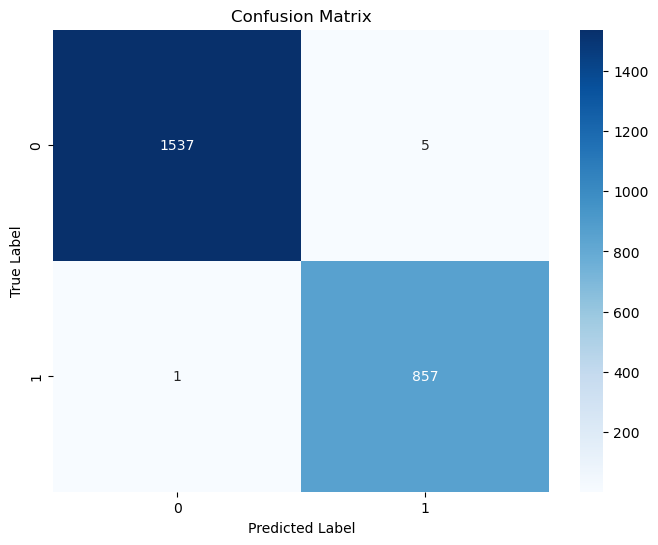

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
len(alll)

15756

In [53]:
def get_random_sample():
    rng = np.random.default_rng()
    idx = rng.integers(0, len(alll))
    return alll[idx]['text'], alll[idx]['label']

In [54]:
sample_html, true_label = get_random_sample()
result = detector.predict(sample_html)
print(f"Is phishing: {result['is_phishing']}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
print(f"Suspicious elements: {result['suspicious_elements']}")
print(f"True label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Is model correct: {result['is_phishing'] == (true_label == 1)}")

2024-12-01 17:51:09,410 - __main__ - INFO - Предсказание: легитимный, уверенность: 1.00


Is phishing: False
Confidence: 1.00
Explanation: Подозрительное количество полей для ввода пароля (3).
Suspicious elements: [{'type': 'form', 'issue': 'Форма отправляет данные на внешний сайт', 'element': '<form action="https://www.my-private-network.co.uk/helpdesk_search/" class="search-form helpie-search-form" name="helpie-search-form" role="custom_search"><span class="main-search pauple-helpie-search...'}, {'type': 'script', 'issue': 'Обнаружен обфусцированный JavaScript-код', 'element': '<script>window._wpemojiSettings = {"baseUrl":"https:\\/\\/s.w.org\\/images\\/core\\/emoji\\/13.1.0\\/72x72\\/","ext":".png","svgUrl":"https:\\/\\/s.w.org\\/images\\/core\\/emoji\\/13.1.0\\/svg\\/","svgExt":".svg","so...'}, {'type': 'iframe', 'issue': 'Подозрительное использование iframe', 'element': '<iframe height="0" src="//www.googletagmanager.com/ns.html?id=GTM-THGMMM" style="display:none;visibility:hidden" width="0"></iframe>'}, {'type': 'hidden_element', 'issue': 'Скрытая форма или поле ввода

In [55]:
def test_model(detector, n_tests=100):
    correct = 0
    for i in range(n_tests):
        sample_html, true_label = get_random_sample()
        result = detector.predict(sample_html)
        correct += result['is_phishing'] == (true_label == 1)
    return correct / n_tests

In [56]:
test_model(detector, n_tests=1000)

2024-12-01 17:51:18,882 - __main__ - INFO - Предсказание: легитимный, уверенность: 1.00
2024-12-01 17:51:18,904 - __main__ - INFO - Предсказание: легитимный, уверенность: 0.95
2024-12-01 17:51:18,927 - __main__ - INFO - Предсказание: легитимный, уверенность: 1.00
2024-12-01 17:51:18,968 - __main__ - INFO - Предсказание: легитимный, уверенность: 1.00
2024-12-01 17:51:19,002 - __main__ - INFO - Предсказание: легитимный, уверенность: 0.88
2024-12-01 17:51:19,042 - __main__ - INFO - Предсказание: легитимный, уверенность: 0.98
2024-12-01 17:51:19,067 - __main__ - INFO - Предсказание: фишинг, уверенность: 0.97
2024-12-01 17:51:19,091 - __main__ - INFO - Предсказание: фишинг, уверенность: 0.96
2024-12-01 17:51:19,112 - __main__ - INFO - Предсказание: легитимный, уверенность: 0.98
2024-12-01 17:51:19,137 - __main__ - INFO - Предсказание: легитимный, уверенность: 1.00
2024-12-01 17:51:19,162 - __main__ - INFO - Предсказание: фишинг, уверенность: 0.91
2024-12-01 17:51:19,209 - __main__ - INFO - 

0.991

In [60]:
feature_imp = pd.DataFrame({
    'feature': detector.feature_names,
    'importance': detector.model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))


Top 10 Most Important Features:
                       feature  importance
19                 text_length    8.690614
7                   link_count    7.595339
8         external_links_ratio    7.176519
21  suspicious_character_ratio    5.755479
36                 html_length    5.752978
26     content-security-policy    5.349108
31                 tag_density    4.958706
14                script_count    4.895613
37             comments_length    4.701177
34     external_resource_ratio    4.657451


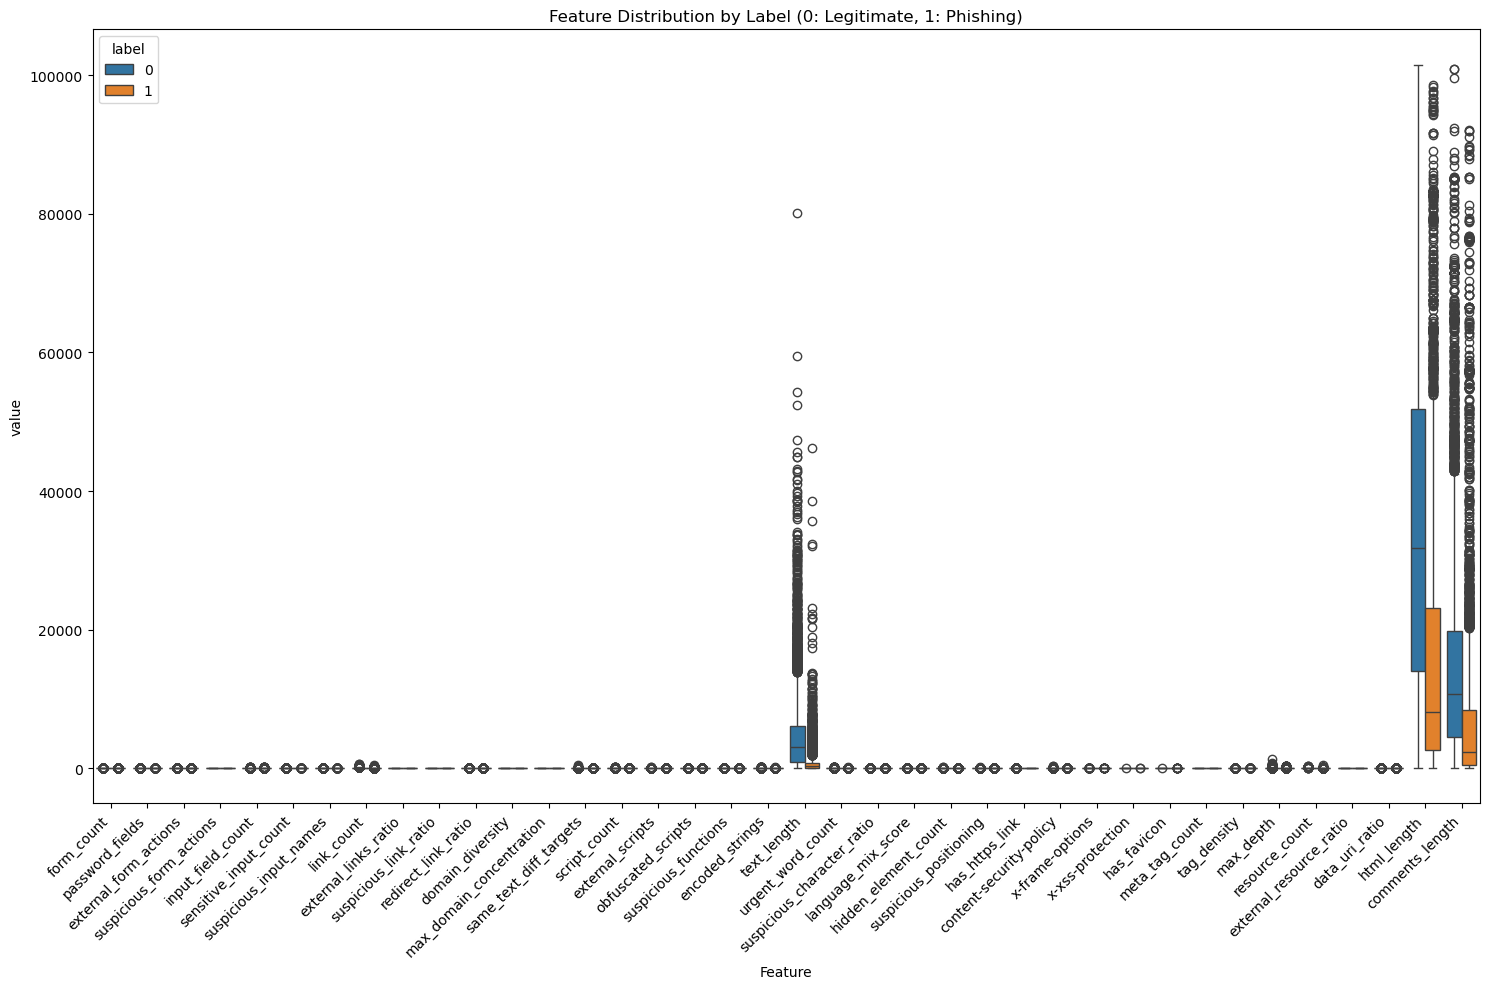

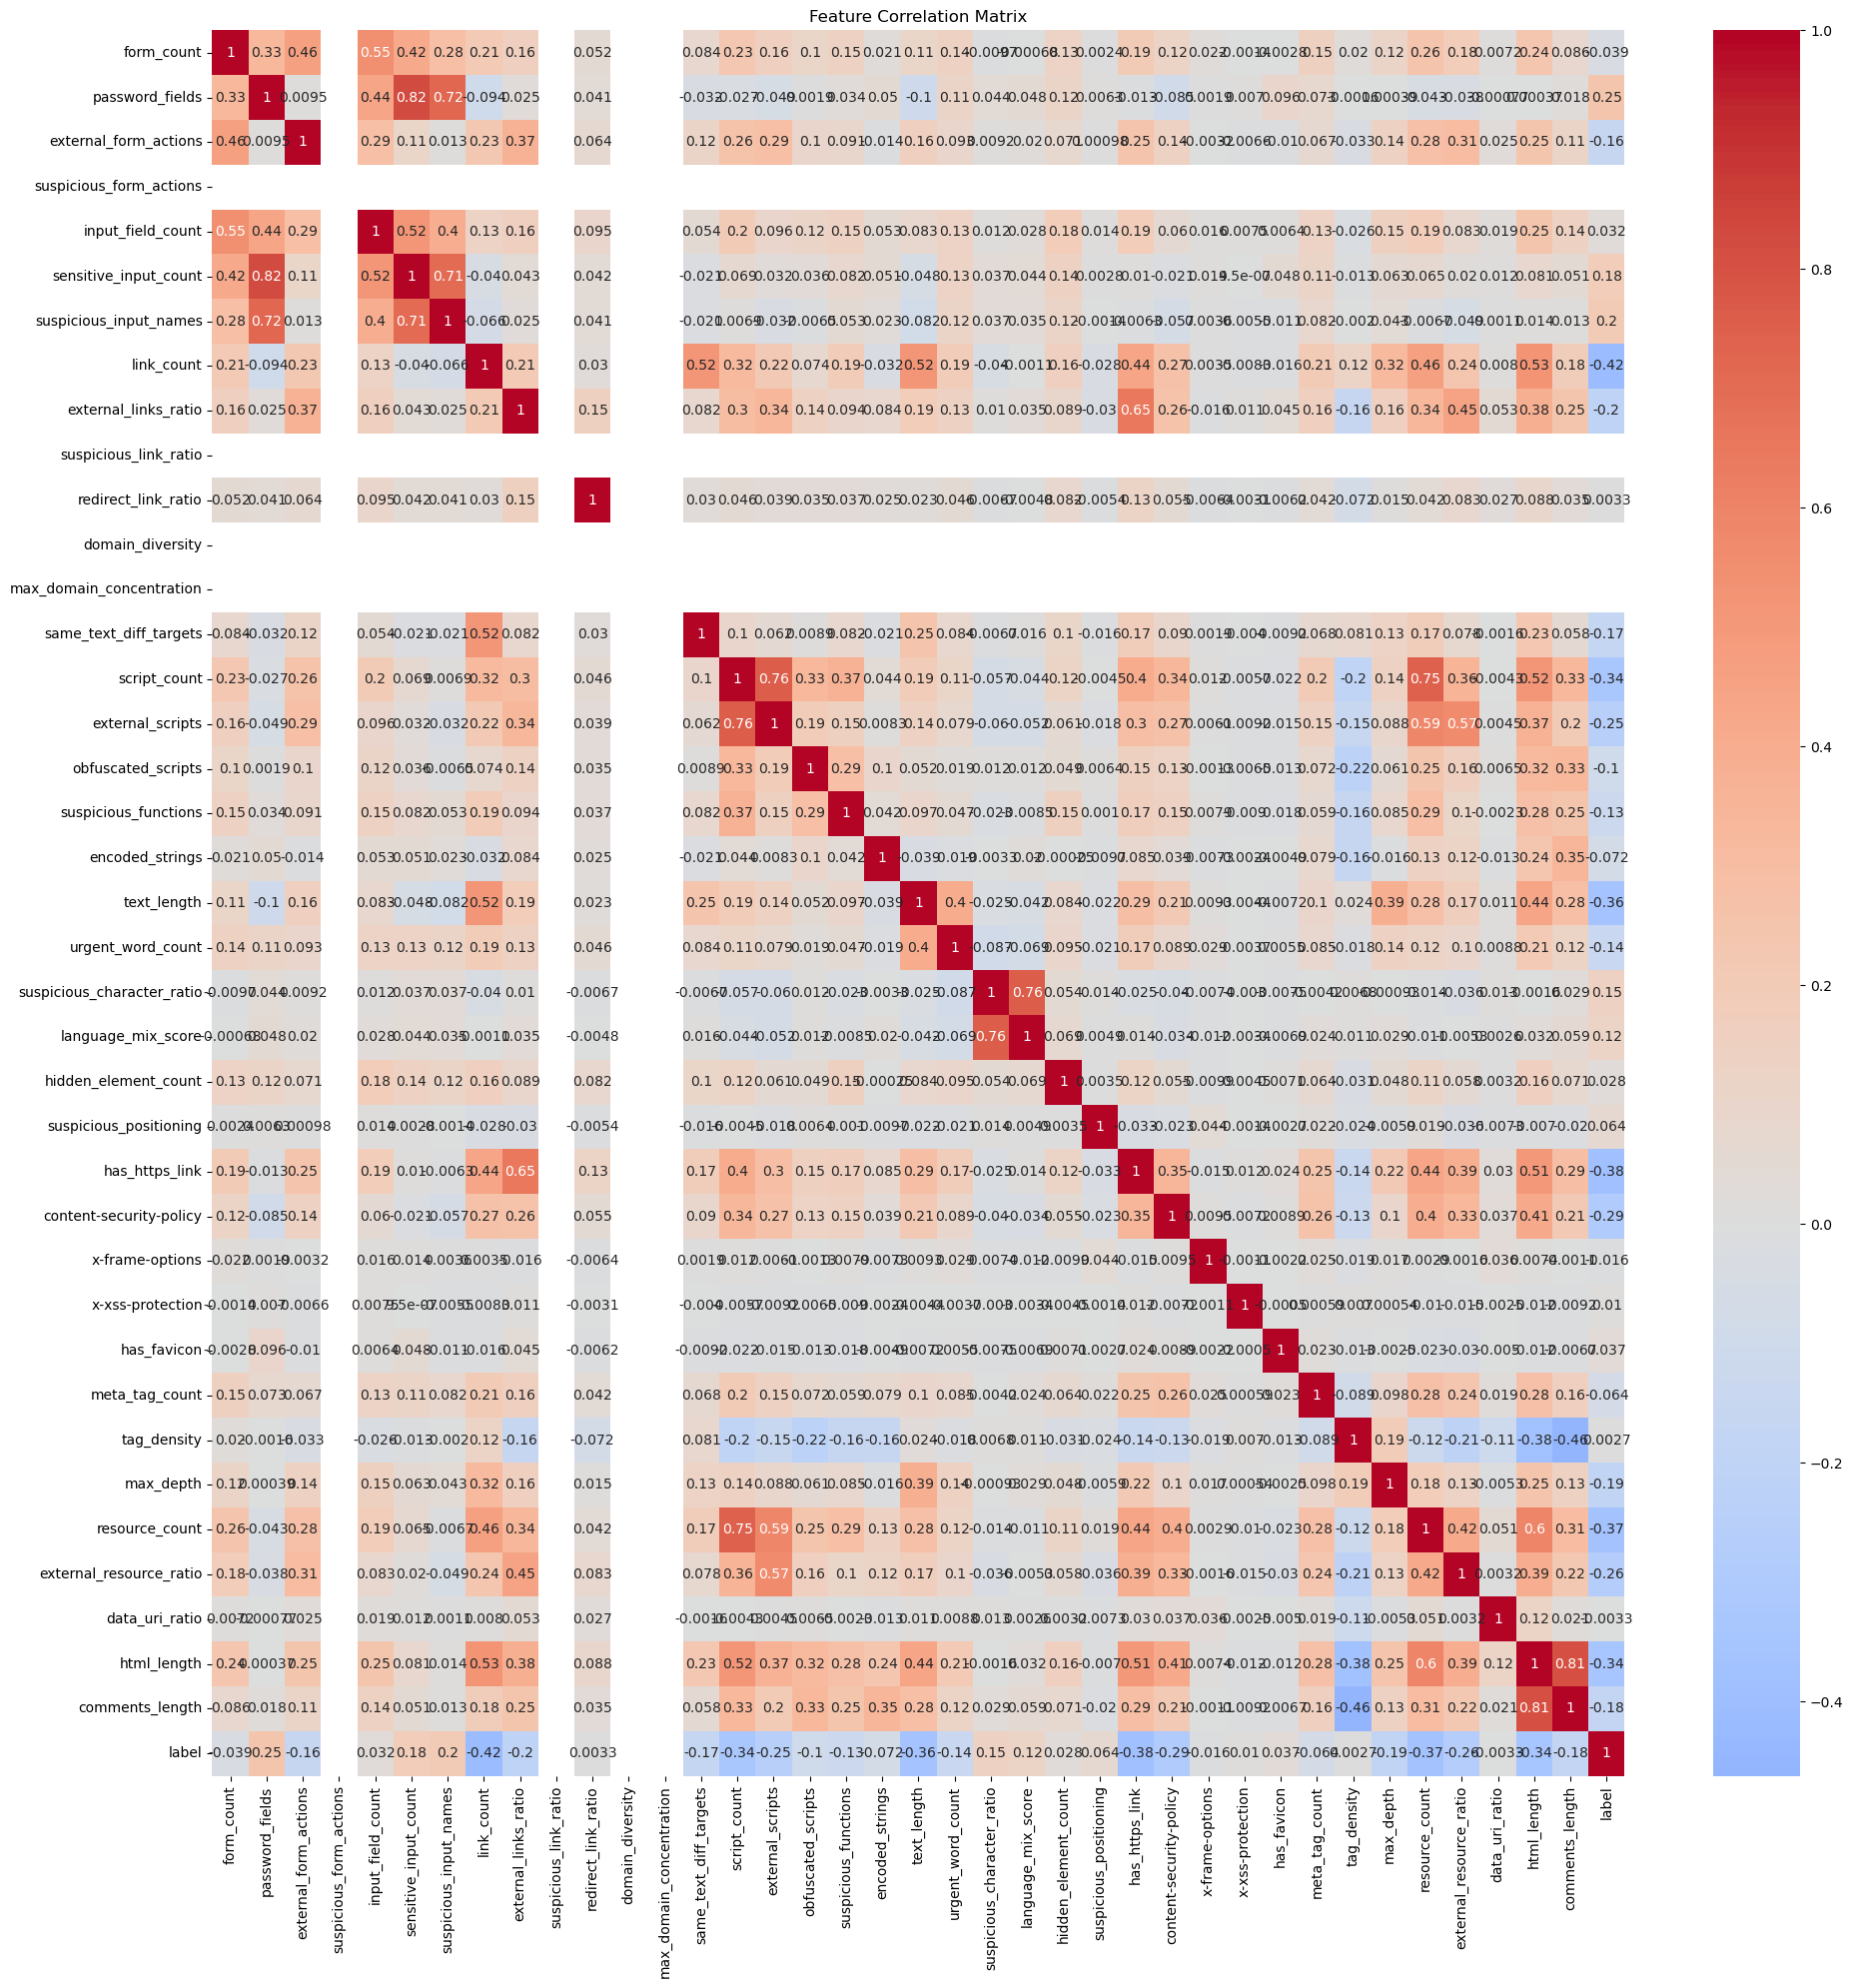

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with features and labels
feature_df = pd.DataFrame(X, columns=detector.feature_names)
feature_df['label'] = y

# Create a figure with larger size
plt.figure(figsize=(15, 10))

# Create a boxplot for each feature, grouped by label
plt.title('Feature Distribution by Label (0: Legitimate, 1: Phishing)')
sns.boxplot(data=feature_df.melt(id_vars=['label'], var_name='Feature'),
            x='Feature', y='value', hue='label')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Additionally, let's create a correlation heatmap
plt.figure(figsize=(20, 20))
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [59]:
result

{'is_phishing': False,
 'confidence': 0.9987210463196772,
 'explanation': 'Подозрительное количество полей для ввода пароля (3).',
 'feature_importance': [('suspicious_input_names', 3.0, 1.5458687232803499),
  ('link_count', 60.0, -1.4298630496342735),
  ('script_count', 37.0, -1.394467944801129),
  ('password_fields', 3.0, 0.9006968172364672),
  ('content-security-policy', 19.0, -0.8163769148724532)],
 'suspicious_elements': [{'type': 'form',
   'issue': 'Форма отправляет данные на внешний сайт',
   'element': '<form action="https://www.my-private-network.co.uk/helpdesk_search/" class="search-form helpie-search-form" name="helpie-search-form" role="custom_search"><span class="main-search pauple-helpie-search...'},
  {'type': 'script',
   'issue': 'Обнаружен обфусцированный JavaScript-код',
   'element': '<script>window._wpemojiSettings = {"baseUrl":"https:\\/\\/s.w.org\\/images\\/core\\/emoji\\/13.1.0\\/72x72\\/","ext":".png","svgUrl":"https:\\/\\/s.w.org\\/images\\/core\\/emoji\\/13.

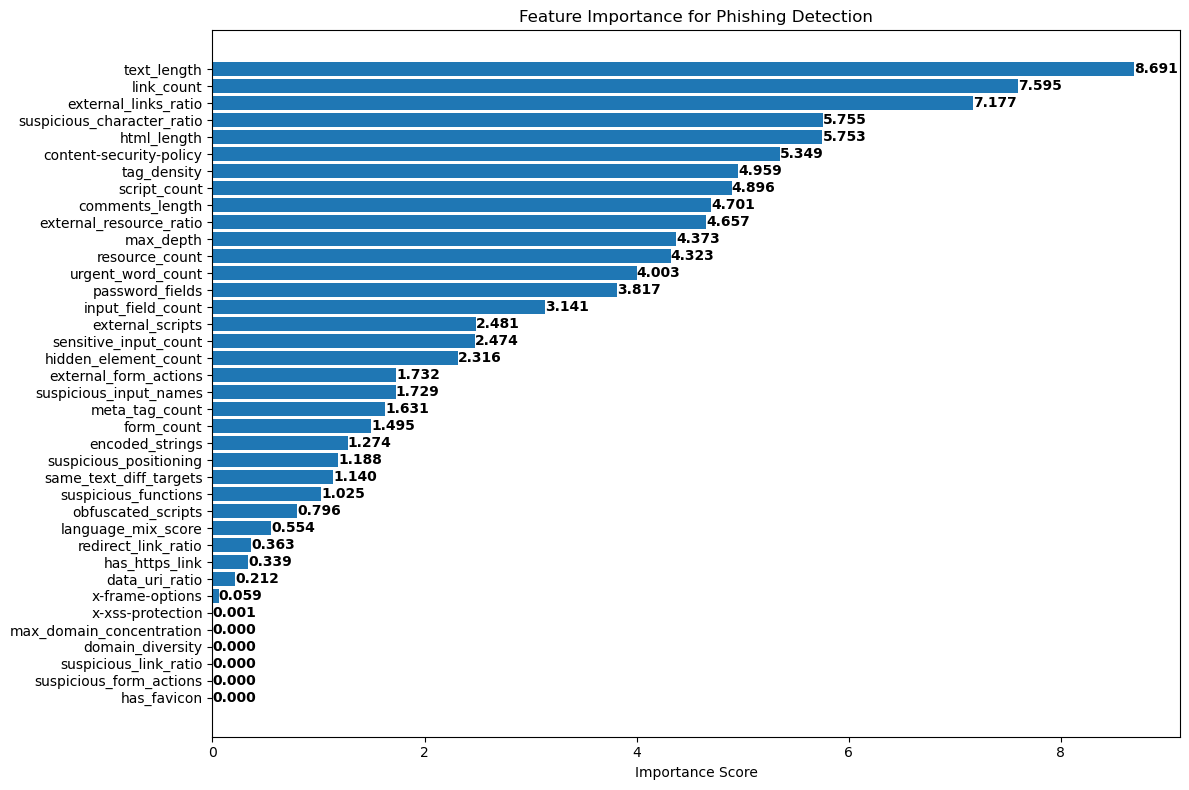


Top features by importance:
text_length: 8.691
link_count: 7.595
external_links_ratio: 7.177
suspicious_character_ratio: 5.755
html_length: 5.753
content-security-policy: 5.349
tag_density: 4.959
script_count: 4.896
comments_length: 4.701
external_resource_ratio: 4.657
max_depth: 4.373
resource_count: 4.323
urgent_word_count: 4.003
password_fields: 3.817
input_field_count: 3.141
external_scripts: 2.481
sensitive_input_count: 2.474
hidden_element_count: 2.316
external_form_actions: 1.732
suspicious_input_names: 1.729
meta_tag_count: 1.631
form_count: 1.495
encoded_strings: 1.274
suspicious_positioning: 1.188
same_text_diff_targets: 1.140
suspicious_functions: 1.025
obfuscated_scripts: 0.796
language_mix_score: 0.554
redirect_link_ratio: 0.363
has_https_link: 0.339
data_uri_ratio: 0.212
x-frame-options: 0.059
x-xss-protection: 0.001
max_domain_concentration: 0.000
domain_diversity: 0.000
suspicious_link_ratio: 0.000
suspicious_form_actions: 0.000
has_favicon: 0.000


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances from the trained model
importances = detector.model.feature_importances_
feature_names = detector.feature_names

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for Phishing Detection')
plt.xlabel('Importance Score')

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Print numerical values
print("\nTop features by importance:")
for idx, row in importance_df.iloc[::-1].iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")